# <strong><font color='red'>Identificación de tendencias y patrones relevantes: **🌡️ Temperatura**.</font></strong>

**Librerías**
<br> Antes de comenzar a explorar nuestros datos, es importante importar las bibliotecas que nos permitirán manipularlos y visualizarlos. Utilizaremos pandas para trabajar con estructuras tipo DataFrame, numpy para funciones numéricas, y seaborn y matplotlib para gráficos.

In [41]:
# Importar librerías 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
import calendar 

## <strong><font color='blue'>1. Cargar conjunto de datos</font></strong> 

Datos reales de temperatura histórica en Chile, específicamente desde estaciones meteorológicas oficiales. Utilizaremos un conjunto de datos disponible públicamente en [GitHub](https://github.com/bastianolea/temperaturas_chile) que recopila temperaturas mínimas y máximas desde 1950 hasta 2024.

In [32]:
# Ruta válida al archivo CSV
url = "https://raw.githubusercontent.com/bastianolea/temperaturas_chile/main/datos/procesados/temperaturas_chile.csv"

# Leer el archivo usando punto y coma como separador
df = pd.read_csv(url, sep=';')

# Limpieza básica
df.columns = df.columns.str.strip()  # Eliminar espacios en nombres de columnas

# Conversión de columna de fecha
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
# Convertir temperaturas a tipo numérico (reemplazar coma por punto si es necesario)
df['t_min'] = pd.to_numeric(df['t_min'].str.replace(',', '.'), errors='coerce')
df['t_max'] = pd.to_numeric(df['t_max'].str.replace(',', '.'), errors='coerce')

# Crear variable temperatura media
df['temperatura_media'] = (df['t_min'] + df['t_max']) / 2

# Verificar que todo esté bien
print(df[['fecha', 't_min', 't_max', 'temperatura_media']].head())

       fecha  t_min  t_max  temperatura_media
0 2013-01-01   16.7   23.9              20.30
1 2013-01-02   16.2   23.5              19.85
2 2013-01-03   20.1   24.3              22.20
3 2013-01-04   17.5   24.4              20.95
4 2013-01-05   19.8   23.9              21.85


## <strong><font color='blue'>2. Preprocesamiento</font></strong> 

In [ ]:
# Filtrar por estación (ejemplo: Santiago)
df = df.dropna(subset=['nombre'])  # Evitar error en str.contains
df_santiago = df[df['nombre'].str.contains("Santiago", case=False, na=False)].copy()
df_santiago = df_santiago.dropna(subset=['fecha', 'temperatura_media'])

In [34]:
# Agrupar por mes y calcular promedio mensual
df_santiago['AñoMes'] = df_santiago['fecha'].dt.to_period('M')
df_mensual = df_santiago.groupby('AñoMes')['temperatura_media'].mean().reset_index()
df_mensual['Fecha'] = df_mensual['AñoMes'].dt.to_timestamp()

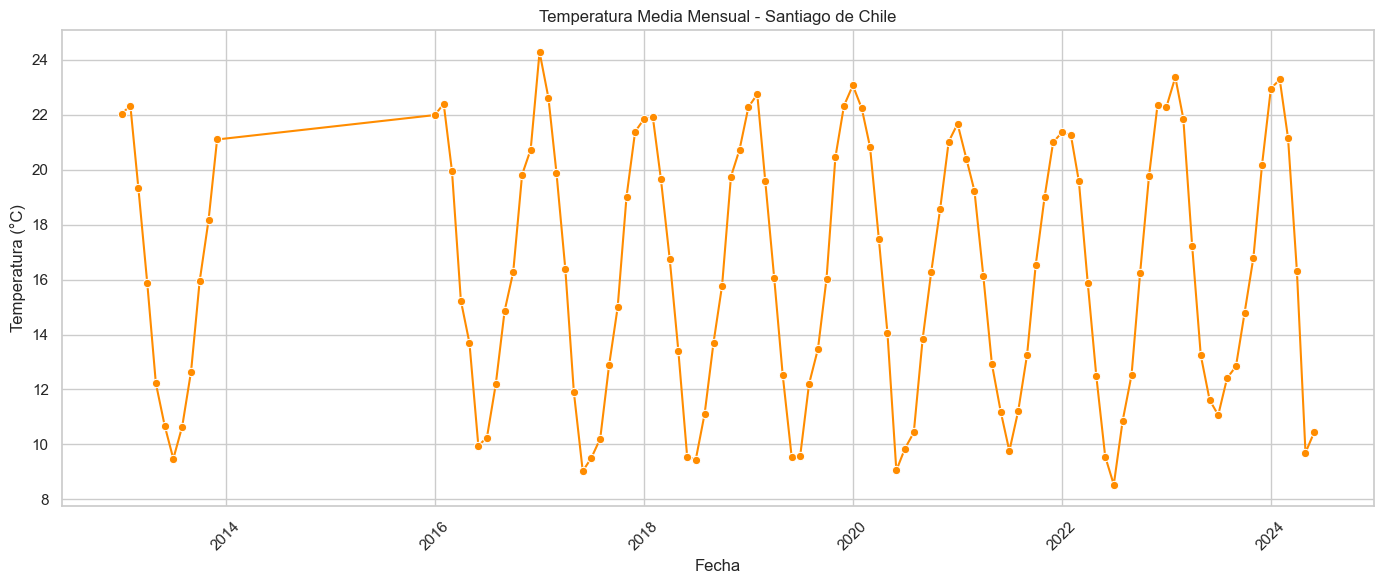

In [35]:
# Visualizar evolución temporal
plt.figure(figsize=(14,6))
sns.lineplot(data=df_mensual, x='Fecha', y='temperatura_media', marker='o', color='darkorange')
plt.title("Temperatura Media Mensual - Santiago de Chile")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
# Descomposición de serie temporal
df_mensual.set_index('Fecha', inplace=True)
decomp = seasonal_decompose(df_mensual['temperatura_media'], model='additive', period=12)

## <strong><font color='blue'>3. Visualización</font></strong> 

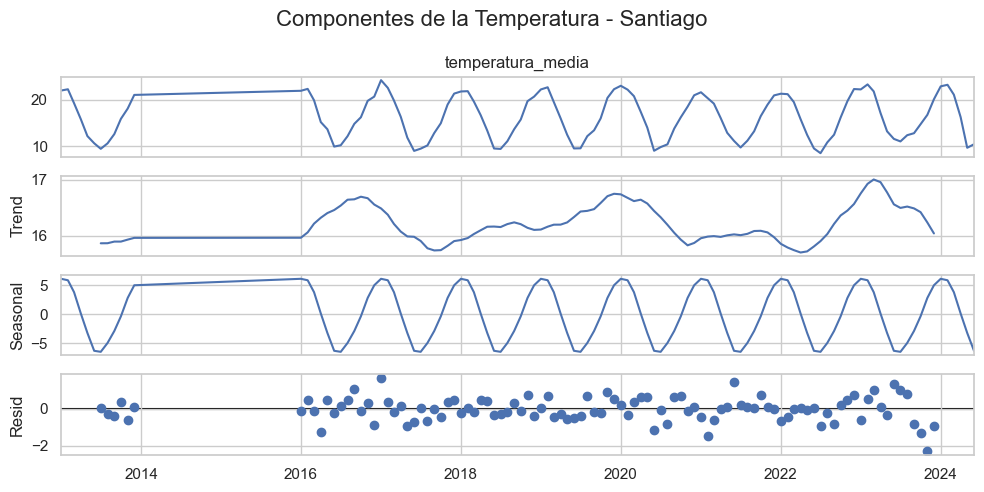

In [37]:
# Graficar componentes: tendencia, estacionalidad y residuales
decomp.plot()
plt.suptitle("Componentes de la Temperatura - Santiago", fontsize=16)
plt.tight_layout()
plt.show()


**Identificar meses más cálidos o fríos**

C:\Users\bernarda.salazar\AppData\Local\Temp\ipykernel_23960\57285277.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_mensual, x='NombreMes', y='temperatura_media', palette='coolwarm')


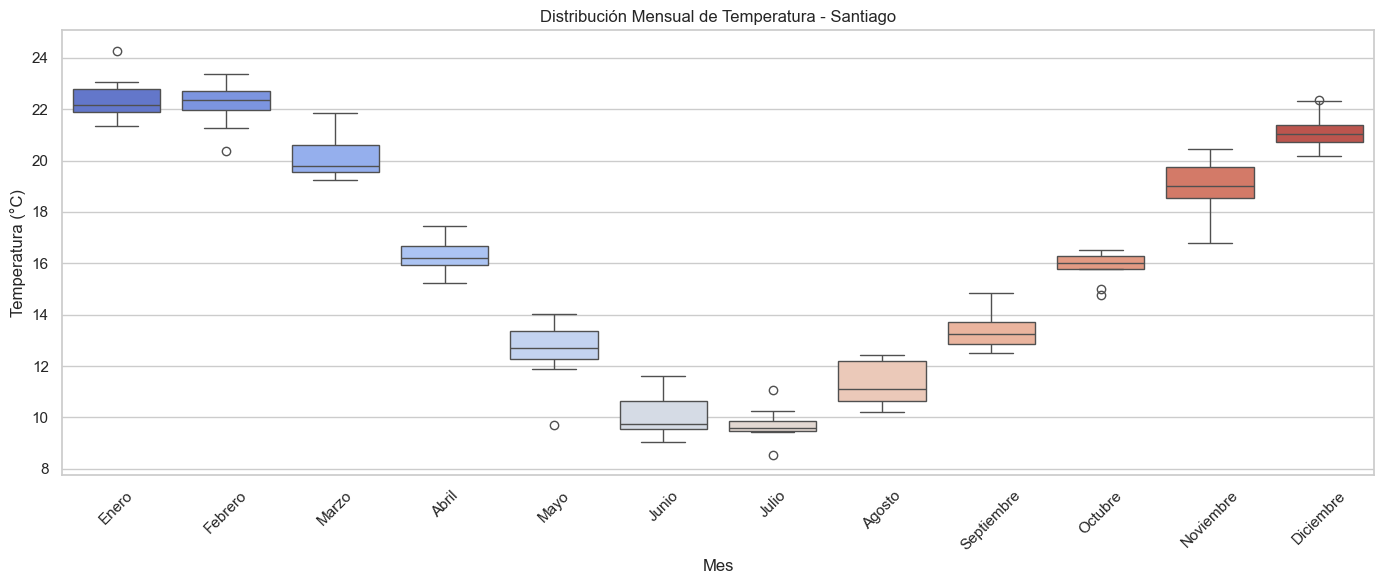

In [40]:
# Crear diccionario con nombres de meses en español
meses_es = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

# Agregar columna con nombre del mes
df_mensual['NombreMes'] = df_mensual['Mes'].map(meses_es)

# Graficar distribución mensual con nombres completos
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_mensual, x='NombreMes', y='temperatura_media', palette='coolwarm')
plt.title("Distribución Mensual de Temperatura - Santiago")
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Comparación entre ciudades**

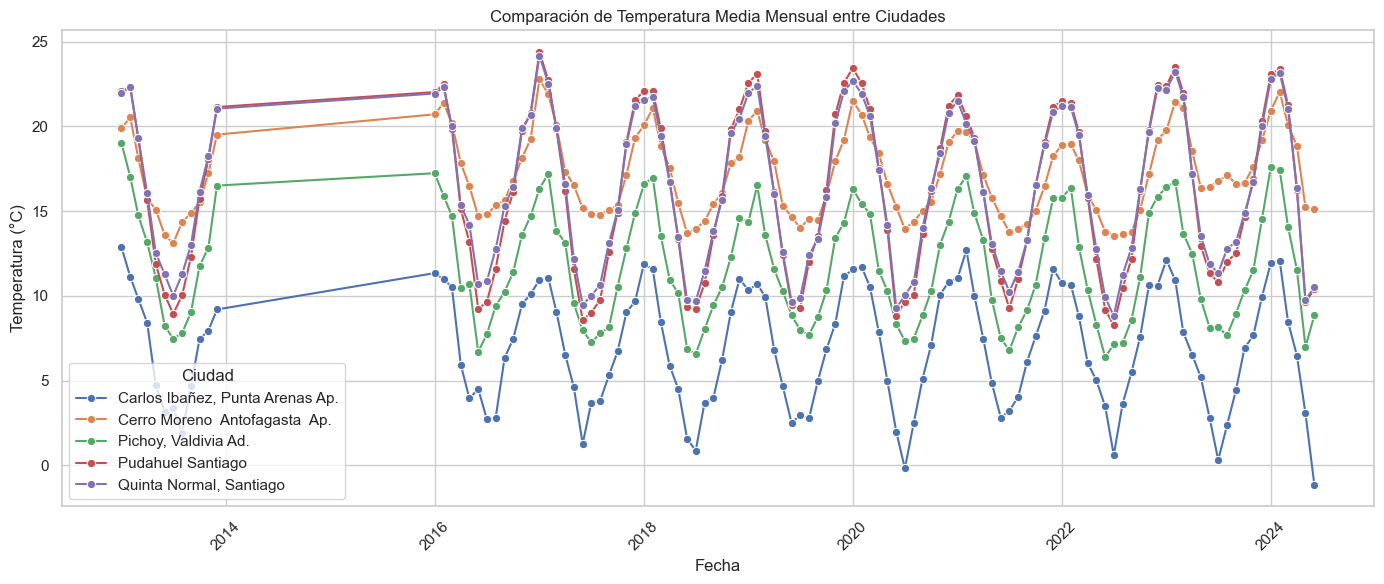

In [42]:
# Seleccionar ciudades para comparar
ciudades = ['Santiago', 'Valdivia', 'Antofagasta', 'Punta Arenas']
df_ciudades = df[df['nombre'].str.contains('|'.join(ciudades), case=False, na=False)].copy()

# Agrupar por ciudad y mes
df_ciudades['AñoMes'] = df_ciudades['fecha'].dt.to_period('M')
df_grouped = df_ciudades.groupby(['nombre', 'AñoMes'])['temperatura_media'].mean().reset_index()
df_grouped['Fecha'] = df_grouped['AñoMes'].dt.to_timestamp()

# Visualizar comparación entre ciudades
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_grouped, x='Fecha', y='temperatura_media', hue='nombre', marker='o')
plt.title("Comparación de Temperatura Media Mensual entre Ciudades")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.xticks(rotation=45)
plt.legend(title="Ciudad")
plt.tight_layout()
plt.show()

## <strong><font color='blue'>4. Detección de anomalías</font></strong> 

🌡️ Las anomalías en las series de temperatura detectadas por el modelo (Isolation Forest en este caso) representan valores que se desvían significativamente del comportamiento esperado o típico para esa ciudad en ese momento.

📉 ¿Cómo los interpreta el modelo?
- Analiza la distribución de la temperatura mensual en cada ciudad.
- Calcula qué puntos se “aislan” fácilmente del resto del conjunto (valores muy alejados).
- Asigna:
    - 1 → normal
    - -1 → anómalo

Por ejemplo, si Santiago tiene una temperatura media de 6°C en enero (cuando suele estar sobre 20°C), el modelo detectará ese mes como una anomalía.

🔍 ¿Qué tipo de anomalías se pueden detectar?
- Eventos climáticos extremos: por ejemplo, olas de calor inusuales en invierno o temperaturas extremadamente bajas en verano.
- Cambios locales por fenómenos naturales: como erupciones volcánicas, incendios forestales o cambios en patrones de viento.
- Errores en los datos: sensores defectuosos, registros duplicados o errores humanos en la medición.

📊 ¿Cómo puedes analizarlo tú?
- Visualmente: los puntos anómalos resaltan en el gráfico con colores o marcadores distintos.
- Estadísticamente: puedes revisar el porcentaje de meses anómalos por ciudad.
- Comparativamente: si una ciudad tiene más anomalías que otras, podrías investigar causas locales (altitud, fenómenos meteorológicos, etc.).

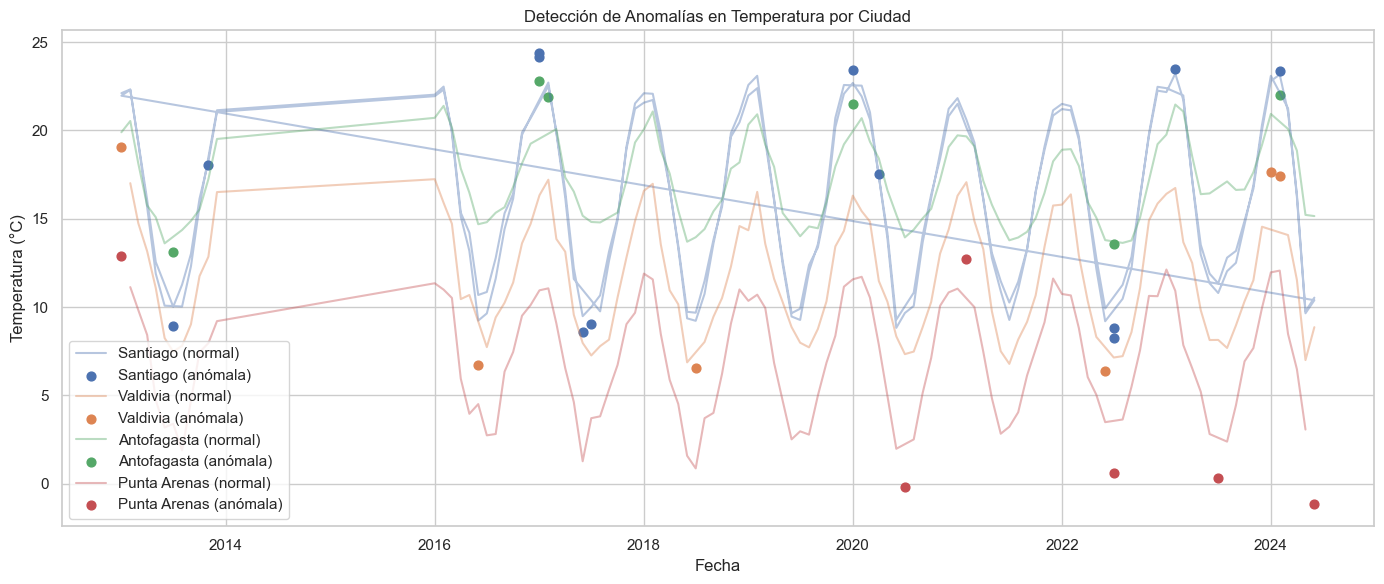

In [43]:
#  Detección de anomalías con Isolation Forest
anomalias = []
for ciudad in ciudades:
    df_c = df_grouped[df_grouped['nombre'].str.contains(ciudad, case=False)].copy()
    modelo = IsolationForest(contamination=0.05, random_state=42)
    df_c['anomaly'] = modelo.fit_predict(df_c[['temperatura_media']])
    df_c['Ciudad'] = ciudad
    anomalias.append(df_c)

df_anomalias = pd.concat(anomalias)

# Visualizar anomalías
plt.figure(figsize=(14, 6))
for ciudad in ciudades:
    df_c = df_anomalias[df_anomalias['Ciudad'] == ciudad]
    normales = df_c[df_c['anomaly'] == 1]
    outliers = df_c[df_c['anomaly'] == -1]
    plt.plot(normales['Fecha'], normales['temperatura_media'], label=f"{ciudad} (normal)", alpha=0.4)
    plt.scatter(outliers['Fecha'], outliers['temperatura_media'], label=f"{ciudad} (anómala)", s=40)

plt.title("Detección de Anomalías en Temperatura por Ciudad")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# Generar resumen por ciudad
resumen = df_anomalias.groupby('Ciudad').agg(
    Total_Registros=('anomaly', 'count'),
    Anomalias=('anomaly', lambda x: (x == -1).sum())
).reset_index()

# Calcular porcentaje
resumen['Porcentaje_Anomalias'] = (resumen['Anomalias'] / resumen['Total_Registros'] * 100).round(2)

# Mostrar tabla final
print(resumen)


         Ciudad  Total_Registros  Anomalias  Porcentaje_Anomalias
0   Antofagasta             3463        171                  4.94
1  Punta Arenas             3466        171                  4.93
2      Santiago             6933        340                  4.90
3      Valdivia             3449        172                  4.99
